<a href="https://colab.research.google.com/github/aidot-kr/AISecurity/blob/master/13_BERT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mxnet
!pip install gluonnlp
!pip install transformers
!pip install sentencepiece
!pip install neattext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 38.5 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl size=681070 sha256=e4b10d859cac7099fa4a936a5cc348fca0081b48903636cba36882b3d95bf2f4
  Stored in directory: /root/.cache/pip/wheels/1a/1e/0d/99f55911d90f2b95b9f7c176d5813ef3622894a4b30fde6bd3
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import os
import gc

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# seed 값 설정
torch.manual_seed(555)

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import transformers
from transformers import AdamW

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path1 = '/content/drive/My Drive/bert/new_dataset3_big.csv'
df = pd.read_csv(file_path1)

In [ ]:
df.head()

,Text,oh_label
0,`- This is not ``creative``. Those are the di...,0
1,- Important note for all sysops: There is a ...,0
2,`:If you ever claimed in a Judaic studies prog...,0
3,"`Someone wrote: More recognizable, perhaps, is...",0
4,gets far more tendentious yet.,0


In [ ]:
df['oh_label'].value_counts()

0    72549
1    72482
Name: oh_label, dtype: int64

In [ ]:
# 데이터 1 칼럼 불필요 한거 없애기
df.isnull().sum()

Text        0
oh_label    0
dtype: int64

In [ ]:
print(df.isnull())

         Text  oh_label
0       False     False
1       False     False
2       False     False
3       False     False
4       False     False
...       ...       ...
145026  False     False
145027  False     False
145028  False     False
145029  False     False
145030  False     False

[145031 rows x 2 columns]


In [ ]:
import neattext as nt
import neattext.functions as nfx
import re

In [ ]:
from html import unescape
# Preprocess text function
def preprocess_text(text):
    # 1. Find #[xX]?\w+; and put '&' to the first
    text = re.sub(r'(^|\D)#\w+;', lambda match: f'&{match.group()}' if match.group().startswith('#') else f'{match.group()[0]}&{match.group()[1:]}', text)
    # 2. Convert HTML character to unicode
    text = unescape(text)
    # 3. Remove http, https
    text = re.sub(r'http\S+|https\S+', '', text)
    # 4. Remove email
    text = re.sub(r'\S+@\S+', '', text)
    # 5. Remove twitter id
    text = re.sub(r'@\w+', '', text)
    # 6. Remove "&lt;/b&gt;"
    text = re.sub(r'&lt;/b&gt;', '', text)
    # 7. Remove &quot; and quot;
    text = re.sub(r'&quot;|quot;', '', text)
    # 8. Replace &amp; and amp; with &
    text = re.sub(r'&amp;|amp;', '&', text)
    # 9. Replace &lt; and lt; with <
    text = re.sub(r'&lt;|lt;', '<', text)
    # 10. Replace &gt; and gt; with >
    text = re.sub(r'&gt;|gt;', '>', text)
    # 11. Remove the text inside parentheses
    text = re.sub(r'\(.*?\)', '', text)
    # 12. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # 13. Remove #
    text = re.sub(r'#[\w]*', '', text)
    # Remove user handles
    text = re.sub(r'@\w+', '', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text

In [ ]:
df['Text'] = df['Text'].apply(preprocess_text)

In [ ]:
df['Text'] = df['Text'].apply(nfx.remove_stopwords)
df.head()

,Text,oh_label
0,`- ``creative``. dictionary definitions terms ...,0
1,- Important note sysops: bug administrative fe...,0
2,`:If claimed Judaic studies program ultra-Orth...,0
3,"`Someone wrote: recognizable, perhaps, type ge...",0
4,gets far tendentious yet.,0


In [ ]:
df1 = df[df['oh_label'] == 1]
df1.head()

,Text,oh_label
17,` :Click ``Annoying Users`` link! guess Massac...,1
19,Iraq good === === USA bad,1
40,` Buddha - ``Some suggest victims referred add...,1
64,____ fuck little asshole. want talk human star...,1
105,"dick, bigger yours! hahaha",1


## Train, Test, Val set
### Tried 0.2 / 0.8 and 0.4/0.6, best result was 0.3 / 0.7

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")



Training set size: 101521
Validation set size: 21755
Test set size: 21755


In [ ]:
df_train.tail()

,Text,oh_label
101516,== fuck == fuck misterwiki. fuck misterwiki. f...,1
101517,` ::::those ``abbreviations`` hyperlinks links...,0
101518,vandalize Wikipedia Page mistake....He new pla...,0
101519,"second look-through, prose smidge choppy place...",0
101520,`I'm putting concentrating things. going touch...,0


## DeBERTa input


In [ ]:
from transformers import DebertaTokenizer, DebertaForSequenceClassification

tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base')


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.den

In [ ]:

tokenizer.vocab_size

50265

In [ ]:

list(tokenizer.get_vocab())[:10]

['[PAD]', '[CLS]', '[SEP]', '[UNK]', '!', '"', '#', '$', '%', '&']

In [ ]:
!nvidia-smi

Mon Jun 12 06:47:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [ ]:
L_RATE = 1e-5
MAX_LEN = 256

BATCH_SIZE = 32
NUM_CORES = os.cpu_count()

NUM_CORES

12

In [ ]:
# train, val
class CompDataset(Dataset):

    def __init__(self, df_train):
        self.df = df_train

    def __getitem__(self, index):
        #print("Accessing index: ", index)
        sentence1 = self.df.loc[index, 'Text']

        encoded_dict = tokenizer.encode_plus(
                    sentence1,
                    add_special_tokens = True,
                    max_length = MAX_LEN,
                    pad_to_max_length = True,
                    truncation=True,
                    return_attention_mask = True,
                    return_tensors = 'pt',
               )

        padded_token_list = encoded_dict['input_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]


        target = torch.tensor(self.df.loc[index, 'oh_label'])

        sample = (padded_token_list, att_mask, target)

        return sample

    def __len__(self):
        return len(self.df)

# test
class TestDataset(Dataset):

    def __init__(self, df_test):
        self.df = df_test

    def __getitem__(self, index):

        sentence1 = self.df.loc[index, 'Text']

        encoded_dict = tokenizer.encode_plus(
                    sentence1,
                    add_special_tokens = True,
                    max_length = MAX_LEN,
                    pad_to_max_length = True,
                    return_attention_mask = True,
                    truncation=True,
                    return_tensors = 'pt',
               )

        padded_token_list = encoded_dict['input_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]

        sample = (padded_token_list, att_mask)

        return sample


    def __len__(self):
        return len(self.df)


In [ ]:
from transformers import DebertaConfig, DebertaForSequenceClassification


config = DebertaConfig.from_pretrained(
    'microsoft/deberta-base',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=0.1,  # dropout rate
    attention_probs_dropout_prob=0.1,
)


model = DebertaForSequenceClassification.from_pretrained(
    'microsoft/deberta-base',
    config=config,
)

model.to(device)




Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.den

"from transformers import RobertaForSequenceClassification\n\nmodel = RobertaForSequenceClassification.from_pretrained(\n    'roberta-large',  # 모델 이름을 roberta-base로 변경\n    num_labels = 2, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.   \n    output_attentions = False, # Whether the model returns attentions weights.\n    output_hidden_states = False, # Whether the model returns all hidden-states.\n    dropout = 0.1, # dropout rate\n)\n\n# model을 device위에 올림\nmodel.to(device)"

In [ ]:
train_data = CompDataset(df_train)
val_data = CompDataset(df_val)
test_data = TestDataset(df_test)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_CORES)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_CORES)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_CORES)

print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

3173
680
680


In [ ]:
len(df)

145031

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Result is better then with 10 epochs
NUM_EPOCHS=5

loss_values = []
acc_values = []
loss_val = []
acc_val = []


from torch.optim import AdamW
from sklearn.metrics import accuracy_score

optimizer = AdamW(model.parameters(), lr=L_RATE)


total_steps = len(train_dataloader) * NUM_EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# 학습 시작
for epoch in range(NUM_EPOCHS):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, NUM_EPOCHS))

    targets_list = []
    preds_list = []

    # ========================================
    #               Training
    # ========================================

    print('Training...')
    # put the model into the training mode
    model.train()

    total_loss = 0

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # clear any previously calculated gradients
        model.zero_grad()

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # get the loss
        loss = outputs.loss

        # add up the train loss
        total_loss += loss.item()

        # perform backpropagation
        loss.backward()

        # update parameters
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Calculate training progress percentage
        progress = (step / len(train_dataloader)) * 100
        print('Training Progress: {:.2f}%'.format(progress), end='\r')

        # Store predictions and targets for accuracy calculation
        preds = torch.argmax(outputs.logits, dim=1)
        targets_list.extend(b_labels.cpu().numpy())
        preds_list.extend(preds.cpu().numpy())

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Calculate accuracy
    avg_train_acc = accuracy_score(targets_list, preds_list)

    print("Average train loss: {}".format(avg_train_loss))
    print("Average train accuracy: {}".format(avg_train_acc))

    # Append the average loss and accuracy
    loss_values.append(avg_train_loss)
    acc_values.append(avg_train_acc)

    # ========================================
    #               Validation
    # ========================================
    print("\nValidation...")

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    val_targets_list = []
    val_preds_list = []

    # Evaluate data for one epoch
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)


        val_loss = outputs.loss
        logits = outputs.logits


        total_eval_loss += val_loss.item()

        # Calculate accuracy
        val_preds = torch.argmax(logits, dim=1)
        val_targets_list.extend(b_labels.cpu().numpy())
        val_preds_list.extend(val_preds.cpu().numpy())

    avg_val_loss = total_eval_loss / len(val_dataloader)
    avg_val_accuracy = accuracy_score(val_targets_list, val_preds_list)
    print("Average validation loss: {}".format(avg_val_loss))
    print("Average validation Accuracy: {}".format(avg_val_accuracy))


    loss_val.append(avg_val_loss)
    acc_val.append(avg_val_accuracy)


======== Epoch 1 / 5 ========
Training...
Average train loss: 0.24402137197145538
Average train accuracy: 0.897341436747077

Validation...
Average validation loss: 0.20594316930784023
Average validation Accuracy: 0.9138129165709032

======== Epoch 2 / 5 ========
Training...
Average train loss: 0.1723113299171058
Average train accuracy: 0.9316890101555343

Validation...
Average validation loss: 0.18984836414456369
Average validation Accuracy: 0.9272810848080901

======== Epoch 3 / 5 ========
Training...
Average train loss: 0.13322851952212914
Average train accuracy: 0.9503747993026074

Validation...
Average validation loss: 0.19024435952031876
Average validation Accuracy: 0.9309584003677316

======== Epoch 4 / 5 ========
Training...
Average train loss: 0.10437831199917856
Average train accuracy: 0.9636626904778322

Validation...
Average validation loss: 0.2354811076879474
Average validation Accuracy: 0.932245460813606

======== Epoch 5 / 5 ========
Training...
Average train loss: 0.085

In [ ]:
# saving model
model.save_pretrained('/content/drive/My Drive/bert/deberta_ver1_base_new')


In [ ]:
from sklearn.metrics import classification_report

test_data = TestDataset(df_test)


test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_CORES)

model.eval()

predictions = []


for j, batch in enumerate(test_dataloader):
    inference_status = 'Batch ' + str(j+1) + ' of ' + str(len(test_dataloader))
    print(inference_status, end='\r')

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs[0]
    preds = torch.argmax(logits, dim=1)
    predictions.extend(preds.cpu().numpy())


y_true = df_test['oh_label']


report = classification_report(y_true, predictions, digits=3)
print(report)


              precision    recall  f1-score   support

           0      0.953     0.916     0.934     10998
           1      0.917     0.954     0.935     10757

    accuracy                          0.935     21755
   macro avg      0.935     0.935     0.935     21755
weighted avg      0.935     0.935     0.935     21755



In [ ]:
'''# TestDataset을 df_test로 초기화
test_data = TestDataset(df_test)

# DataLoader를 다시 초기화
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_CORES)

model.eval() #모델 평가모드로 전환 (추가함)

# 테스트 시작 (XML-RoBERTa)
for j, batch in enumerate(test_dataloader):
    inference_status = 'Batch ' + str(j+1) + ' of ' + str(len(test_dataloader))
    print(inference_status, end='\r')

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    with torch.no_grad():  # 기울기 계산 비활성화
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    # 예측값
    preds = outputs[0]
    preds = preds.detach().cpu().numpy()

    if j == 0:
        stacked_preds = preds
    else:
        stacked_preds = np.vstack((stacked_preds, preds))

# 예측값에 대한 가장 가능성 높은 라벨 선택
preds = np.argmax(stacked_preds, axis=1)

# 라벨을 각 댓글 유형에 맞게 변환
la=[]
for i in preds:
    if i == 0:
        la.append("일반 댓글")
    elif i == 1:
        la.append("악성 댓글")

# 결과를 df_test에 할당
df_test['label'] = la

# 수정된 df_test 확인
df_test[:10]'''


,Text,oh_label,label
0,"excuse me? girls rape, racist gay jokes? Vamps...",1,악성 댓글
1,hehe. i'm copying status url pasting lot. :P l...,1,일반 댓글
2,feel car rocking wind. freaky.,1,일반 댓글
3,girl tried bully high school outed fam best fr...,1,악성 댓글
4,like think nigga cocoon rape jokes 666 written...,1,악성 댓글
5,"Christians Sri Lanka continue vulnerable, radi...",1,악성 댓글
6,"""\\xc2\\xa0Popes Gone Wild: Catholic Church Fo...",0,일반 댓글
7,Fuck yall dumb ass niggers wit jokes im Chines...,1,악성 댓글
8,lucky find swap &amp; sell normal price. usall...,1,일반 댓글
9,black lady freaking cuz prego guy wears cupcak...,1,악성 댓글


In [ ]:
print(len(y_true))
print(len(predictions))


21755
21755


In [ ]:
def predict_random_data(df):
    random_index = random.choice(df.index.tolist())
    random_text = df.loc[random_index, 'Text']
    prediction = predict_single_sentence(random_text)
    return random_text, prediction

random_text, prediction = predict_random_data(df)
print("Text:", random_text)
print("Prediction:", prediction)

Text: == past behavior indicates willingness engage edit war Sonic & All-Stars Racing Transformed == noting past behavior suggests, engaged multiple edit wars months already. earnestly believe Danica Patrick's origin video game, provide citation talk page, suggested. Thank you.
Prediction: Non-malicious comment


In [ ]:
predict_single_sentence("fuck you")


'Malicious comment'

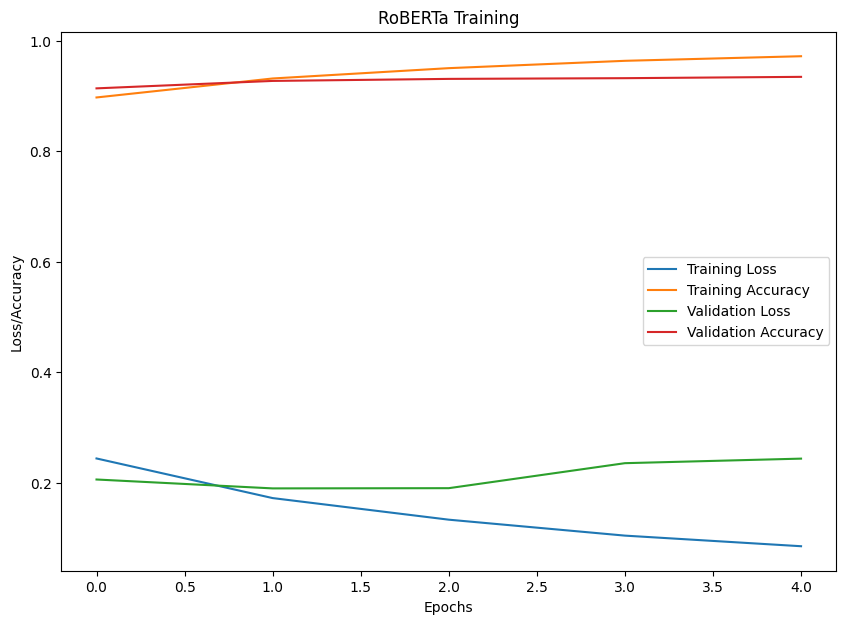

In [ ]:
import matplotlib.pyplot as plt

# 추가한 코드
plt.figure(figsize=(10, 7))
plt.plot(loss_values, label = "Training Loss")
plt.plot(acc_values, label = "Training Accuracy")
plt.plot(loss_val, label="Validation Loss")
plt.plot(acc_val, label ="Validation Accuracy")


plt.title('RoBERTa Training')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

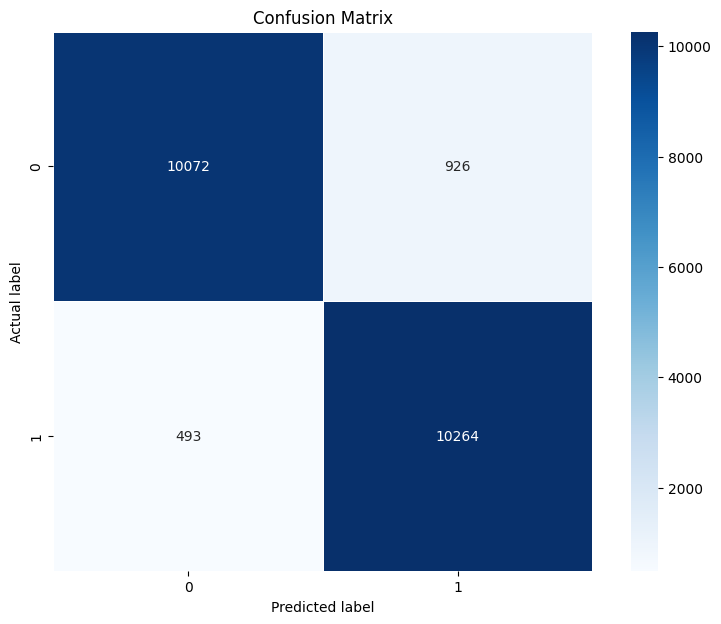

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_true, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()